# Recommending Conversations on Twitter

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

# exploratory analysis

In this dataset, we extract all the conversations for three popular users

- MashiRafael
- aguschmer
- KarlaMoralesR

In [3]:
ds = pd.read_csv(
    '/Users/johnny/data/twitter/conv-users-ec/conversations.csv', 
    parse_dates=['timestamp'])
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520263 entries, 0 to 520262
Data columns (total 10 columns):
id                       520263 non-null int64
screen_name              520263 non-null object
latitude                 4063 non-null float64
longitude                4063 non-null float64
in_reply_to_status_id    507354 non-null float64
text                     520263 non-null object
timestamp                520247 non-null datetime64[ns]
conversation_id          520263 non-null int64
conversation_deep        520263 non-null int64
url                      520263 non-null object
dtypes: datetime64[ns](1), float64(3), int64(3), object(3)
memory usage: 39.7+ MB


520K tweets in the dataset, including: those popular users' tweets and all the replies.

## temporal distribution

Let's analyze the temporal distribution of the tweets

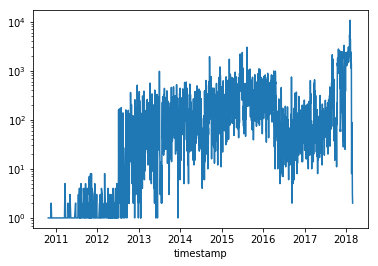

In [4]:
ds.groupby(ds['timestamp'].dt.date).size().plot()
plt.yscale('log')

the tweets begin in 2010, then steadily increase through the years with a  spike in 2018 probably the referendum in february

## most active users

In [5]:
ds.groupby('screen_name').size().sort_values(ascending=False).head()

screen_name
MashiRafael      6212
aguschmer        6140
KarlaMoralesR    2575
marceloht40      1617
sejusto2015       834
dtype: int64

## number of tweets that start conversations

In [6]:
conv_users = ds[ds.in_reply_to_status_id.isnull()].groupby('screen_name')
conv_users.size().sort_values(ascending=False).head()

screen_name
aguschmer        5257
MashiRafael      5060
KarlaMoralesR    1768
adeljar            11
la_abogada_        11
dtype: int64

In [7]:
print(conv_users.size().shape[0])

652


## number of participants by conversation starter

In [8]:
participants_by_conv_starter = []
pcs = {}

for name, group in conv_users:
    conv_ids = group.id.values
    #conv_ids = ds[ds.screen_name==name].head().groupby('conversation_id').size().index.values
    conv_tweets = ds[ds.conversation_id.isin(conv_ids)]
    #print(name, conv_tweets.shape[0], conv_tweets.screen_name.nunique())
    participants_by_conv_starter.append((name, conv_tweets.shape[0], conv_tweets.screen_name.nunique()))
    pcs[name] = set(conv_tweets.screen_name.unique())
    #break

ds_participants = pd.DataFrame(participants_by_conv_starter, columns=['screen_name','num_replies','num_participants'])
ds_participants.sort_values(by='num_replies', ascending=False).head()

,screen_name,num_replies,num_participants
208,MashiRafael,413805,97682
326,aguschmer,79425,24219
173,KarlaMoralesR,12355,5290
36,BatichicaRC,489,207
579,pametroya,393,157


In [9]:
intersect = pcs['MashiRafael'].intersection(pcs['aguschmer'])
intersect2 = pcs['MashiRafael'].intersection(pcs['KarlaMoralesR'])
intersect3 = pcs['aguschmer'].intersection(pcs['KarlaMoralesR'])
print(len(intersect))
print(len(intersect2))
print(len(intersect3))

7699
2138
1945


In [10]:
import networkx as nx
import numpy as np

In [11]:
#G.add_nodes_from(ds_participants.screen_name.values)

name_list=['MashiRafael','KarlaMoralesR','aguschmer']
color_list=['green', 'red', 'blue']
nodes_color = []
i = 0
G = nx.DiGraph()

for name, color in zip(name_list, color_list):
    nodes = list(pcs[name])
    sample_nodes=np.random.choice(nodes, int(len(nodes)*0.02),replace=False)
    for e in sample_nodes:
        G.add_edge(e, name)
        
name_list= []
name_list.append(('MashiRafael','aguschmer'))
name_list.append(('MashiRafael','KarlaMoralesR'))
name_list.append(('aguschmer','KarlaMoralesR'))

node_list = []
node_list.append(intersect)
node_list.append(intersect2)
node_list.append(intersect3)
intergroup = []

for names, nodes_ in zip(name_list, node_list):
    nodes = list(nodes_)
    sample_nodes = np.random.choice(nodes, int(len(nodes)*0.05), replace=False)

    for e in sample_nodes:
        G.add_edge(e, names[0])
        G.add_edge(e, names[1])
        intergroup.append(e)

{'MashiRafael': Text(-0.0698278,0.452496,'MashiRafael'),
 'KarlaMoralesR': Text(-0.577164,-0.59597,'KarlaMoralesR'),
 'aguschmer': Text(0.208664,-0.876724,'aguschmer')}

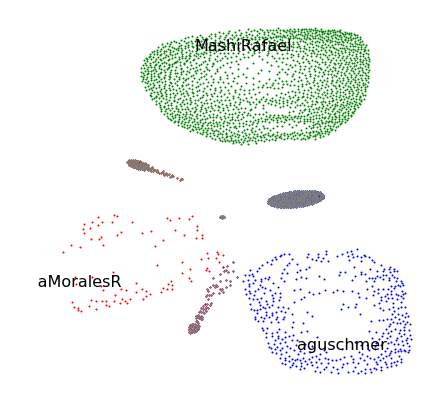

In [307]:
plt.figure
fig, ax = plt.subplots(figsize=(7,7))
ax.axis('off')
pos = nx.spring_layout(G,k=0.10,iterations=50)
group = list(G.predecessors('MashiRafael'))
nx.draw_networkx_nodes(G,pos=pos, with_labels=False,node_size=1, ax=ax, nodelist=group, node_color='green', node_shape='o')
group = list(G.predecessors('aguschmer'))
nx.draw_networkx_nodes(G,pos=pos, with_labels=False,node_size=1, ax=ax, nodelist=group, node_color='blue', node_shape='o')
group = list(G.predecessors('KarlaMoralesR'))
nx.draw_networkx_nodes(G,pos=pos, with_labels=False,node_size=1, ax=ax, nodelist=group, node_color='red', node_shape='o')
nx.draw_networkx_nodes(G,pos=pos, with_labels=False,node_size=1, ax=ax, nodelist=intergroup, node_color='grey', node_shape='x')
group=['MashiRafael','KarlaMoralesR','aguschmer']
labels = {name:name for name in group}
nx.draw_networkx_labels(G,pos,labels,font_size=16,font_color='black')

## sample conversations 

In [12]:
name_list=['MashiRafael','KarlaMoralesR','aguschmer']
conv_users = ds[ds.in_reply_to_status_id.isnull()]
conv_users = conv_users[conv_users.screen_name.isin(name_list)].groupby('screen_name')
users = {}
tweets  =[]

for name, group in conv_users:
    conv_ids= group.sample(5, random_state=1).conversation_id.values
    conv_tweets = ds[ds.conversation_id.isin(conv_ids)]
    conv_parts = conv_tweets.screen_name.nunique()    
    users[name] = set(conv_tweets.screen_name.unique())
    t=conv_tweets.groupby('screen_name').agg({'id': 'max'}).reset_index()
    tweets.extend(list(zip(t['screen_name'].values,t['id'].values)))
    print(name, conv_tweets.shape[0], conv_parts)

KarlaMoralesR 10 6
MashiRafael 159 117
aguschmer 34 30


In [13]:
user_list =[]
for key,value in users.items():
    user_list.extend(list(value))
    for key2,value2 in users.items():
        if key==key2:
            continue
        print(key,key2, len(list(value.intersection(value2))))

KarlaMoralesR MashiRafael 0
KarlaMoralesR aguschmer 0
MashiRafael KarlaMoralesR 0
MashiRafael aguschmer 0
aguschmer KarlaMoralesR 0
aguschmer MashiRafael 0


not intersection between users! we can use this sample as small dataset prediction

In [14]:
users_to_crawl = pd.DataFrame(data=tweets, columns=['name', 'tweet_id'])
users_to_crawl.shape

(153, 2)

In [15]:
users_to_crawl.head()

,name,tweet_id
0,KarlaMoralesR,864679238045249545
1,TitoTacitus,746192692460191744
2,WilsonMerinoR,852353945007685632
3,andresgaraym,864680292191272963
4,ernestoColon20,753038888420147200


In [295]:
users_to_crawl.to_csv('/Users/johnny/data/twitter/sample_users_conv.csv', index=False)